SUDA NAVEEN 
20MIC0057
Forecasting Unit Sales

# Time Series Forecasting Project

## Introduction

In this project, I am tasked with building a time series forecasting model to predict the number of units sold for each item ID using dummy sales data from Amazon. The data includes various attributes such as date, Item ID, Item Name, anarix_id, ad_spend, units (target), orderedrevenueamount, and unit_price. My objective is to leverage this data to accurately forecast sales and to provide insights into the factors influencing these sales.

## Objectives

**Primary Task:** The primary goal is to develop a time series forecasting model that predicts the number of units sold for each item ID. I will use the Mean Squared Error (MSE) as the evaluation metric to assess the accuracy of the model. The dataset contains various features, and I aim to utilize these effectively to enhance the predictive performance.

**Bonus Task:** In the second task, I am required to predict unit sales without utilizing the ad_spend feature. This will help to understand the model's performance when deprived of advertising spend data, which could be crucial for decision-making in scenarios where ad spend information is unavailable or unreliable.

## Approach

My approach to this project involves the following key steps:

1. **Data Loading and Exploration**

   I start by loading the training and test datasets, ensuring that the date column is parsed correctly as a datetime object. This step is crucial because time series forecasting inherently depends on the chronological order of data.

   I then perform an initial inspection of the data to understand its structure, identify any missing values, and get an overview of the distribution of the features. This exploratory data analysis (EDA) helps me to identify patterns, outliers, and relationships between the features, which are essential for feature engineering and model building.

2. **Feature Engineering**

   Feature engineering is a critical step where I transform raw data into meaningful features that improve the model's performance. Here, I extract additional date-related features such as the year, month, day, and day of the week. These features help capture seasonality, trends, and other time-dependent patterns in the sales data.

   Additionally, I aggregate the data by Item ID and the newly created date features. This aggregation ensures that the data is appropriately structured for time series analysis and forecasting.

3. **Model Selection and Training**

   For model selection, I use XGBoost, a powerful gradient boosting algorithm that is well-suited for regression tasks. I split the data into training and validation sets to evaluate the model's performance and avoid overfitting. Feature scaling is also applied to ensure that the model can handle features with different scales effectively.

   After an initial round of training, I perform hyperparameter tuning using GridSearchCV to identify the best set of parameters for the model. This tuning helps in optimizing the model's performance by exploring various combinations of hyperparameters.

4. **Evaluation and Visualization**

   The model's performance is evaluated using the Mean Squared Error (MSE) on the validation set. Lower MSE values indicate better predictive accuracy. I also visualize the actual versus predicted units sold to gain insights into the model's effectiveness.

   For both the primary and bonus tasks, I create visualizations that compare the actual and predicted sales values. These plots help in understanding how well the model captures the underlying patterns in the data. I make sure to include my registration number "20MIC0057" in all the visualizations for identification purposes.

5. **Bonus Task: Predicting Without Ad Spend**

   In the bonus task, I drop the ad_spend feature and retrain the model. This step is essential for understanding how much the model relies on advertising spend to make accurate predictions. By comparing the MSE and visualizing the results, I can assess the model's robustness when deprived of this critical feature.

   Finally, I display the predictions directly in the notebook to ensure that they are correctly generated and ready for submission.

## Conclusion

Through this project, I aim to demonstrate my ability to handle time series data, perform feature engineering, and build robust forecasting models. The detailed exploration and visualization of results, coupled with model tuning, are expected to yield insights that could be valuable for decision-making in a real-world scenario.


Importing required files

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

loading data

In [23]:
train_df = pd.read_csv('train.csv', parse_dates=['date'])
test_df = pd.read_csv('test.csv', parse_dates=['date'])

preprocessing

In [24]:
train_df.info()
train_df.describe()
train_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101490 entries, 0 to 101489
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ID          101490 non-null  object        
 1   date        101490 non-null  datetime64[ns]
 2   Item Id     101488 non-null  object        
 3   Item Name   99658 non-null   object        
 4   ad_spend    77303 non-null   float64       
 5   anarix_id   101490 non-null  object        
 6   units       83592 non-null   float64       
 7   unit_price  101490 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 6.2+ MB


ID                0
date              0
Item Id           2
Item Name      1832
ad_spend      24187
anarix_id         0
units         17898
unit_price        0
dtype: int64

visualization salse and time

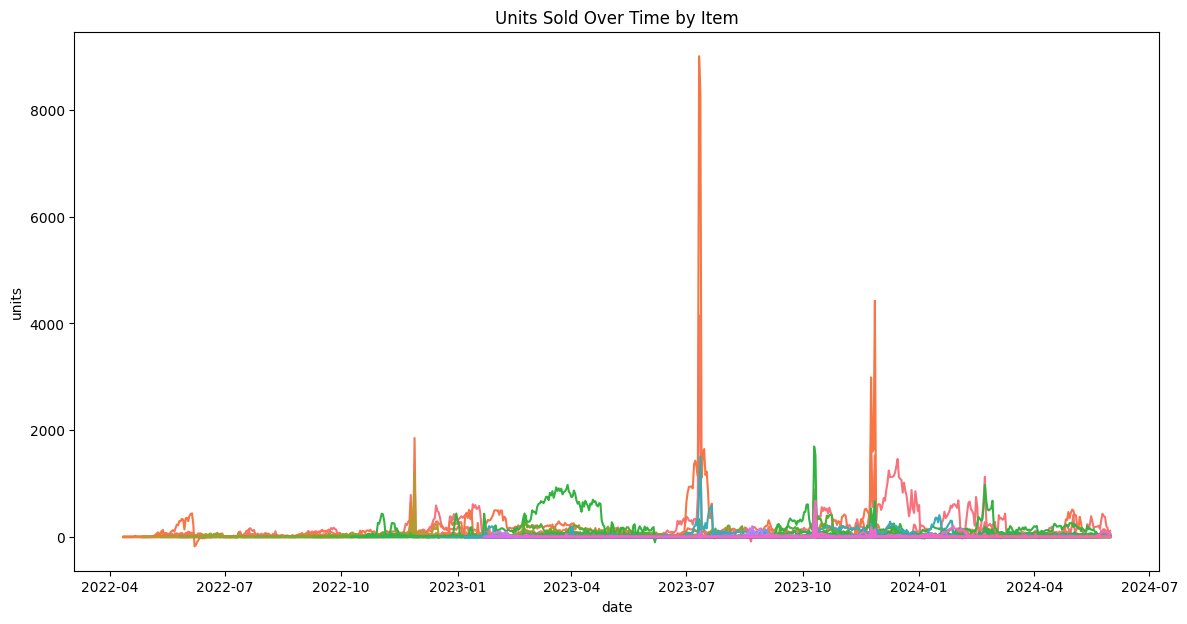

In [25]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=train_df, x='date', y='units', hue='Item Id', legend=None)
plt.title('Units Sold Over Time by Item')
plt.show()

In [26]:
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

In [27]:
train_df_grouped = train_df.groupby(['Item Id', 'year', 'month', 'day', 'dayofweek']).agg({
    'ad_spend': 'sum',
    'units': 'sum',
    'unit_price': 'mean'
}).reset_index()

test_df_grouped = test_df.groupby(['Item Id', 'year', 'month', 'day', 'dayofweek']).agg({
    'ad_spend': 'sum',
    'unit_price': 'mean'
}).reset_index()

model selection

In [28]:
X = train_df_grouped.drop(columns=['units'])
y = train_df_grouped['units']

X_test = test_df_grouped.copy()

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[['ad_spend', 'unit_price']])
X_val_scaled = scaler.transform(X_val[['ad_spend', 'unit_price']])
X_test_scaled = scaler.transform(X_test[['ad_spend', 'unit_price']])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=['ad_spend', 'unit_price'])
X_val_scaled = pd.DataFrame(X_val_scaled, columns=['ad_spend', 'unit_price'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['ad_spend', 'unit_price'])

training

In [31]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Hyperparameter Tuning

In [32]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


evaluation

In [33]:
y_val_pred = best_model.predict(X_val_scaled)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Validation MSE: {mse}")

Validation MSE: 800.3696653707689


Feature Importance vis

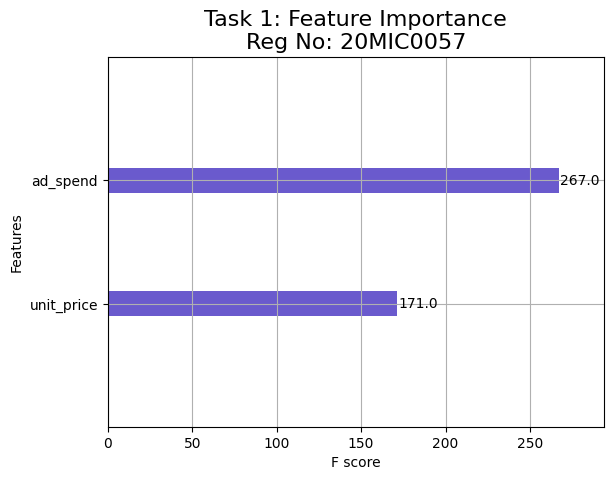

In [34]:
xgb.plot_importance(best_model, max_num_features=10, importance_type='weight', color='slateblue')
plt.title('Task 1: Feature Importance\nReg No: 20MIC0057', fontsize=16)
plt.show()

predictions

In [35]:
y_test_pred = best_model.predict(X_test_scaled)

submission = test_df[['date', 'Item Id']].copy()
submission['TARGET'] = y_test_pred
print(submission.head(15))
"""print(submission.to_csv('submission.csv', index=False)"""

         date     Item Id     TARGET
0  2024-07-01  B09KDR64LT  17.201189
1  2024-07-01  B09KDTS4DC   5.735999
2  2024-07-01  B09KDTHJ6V  13.156240
3  2024-07-01  B09KDQ2BWY  17.122910
4  2024-07-01  B09KDYY3SB   1.264941
5  2024-07-01  B09KDNYCYR   1.264941
6  2024-07-01  B09KDN7PYR   1.264941
7  2024-07-01  B09KDLQ2GW   1.264941
8  2024-07-01  B0BDRTZTGX   1.264941
9  2024-07-01  B09KDVXTP4   1.264941
10 2024-07-01  B09KDPXYG3   1.264941
11 2024-07-01  B09KDW1YKQ   1.264941
12 2024-07-01  B09MR36MLJ  17.201189
13 2024-07-01  B09KDZQJ6P   1.264941
14 2024-07-01  B09MR3Y296   3.241009


"print(submission.to_csv('submission.csv', index=False)"

Predicted vs Actual

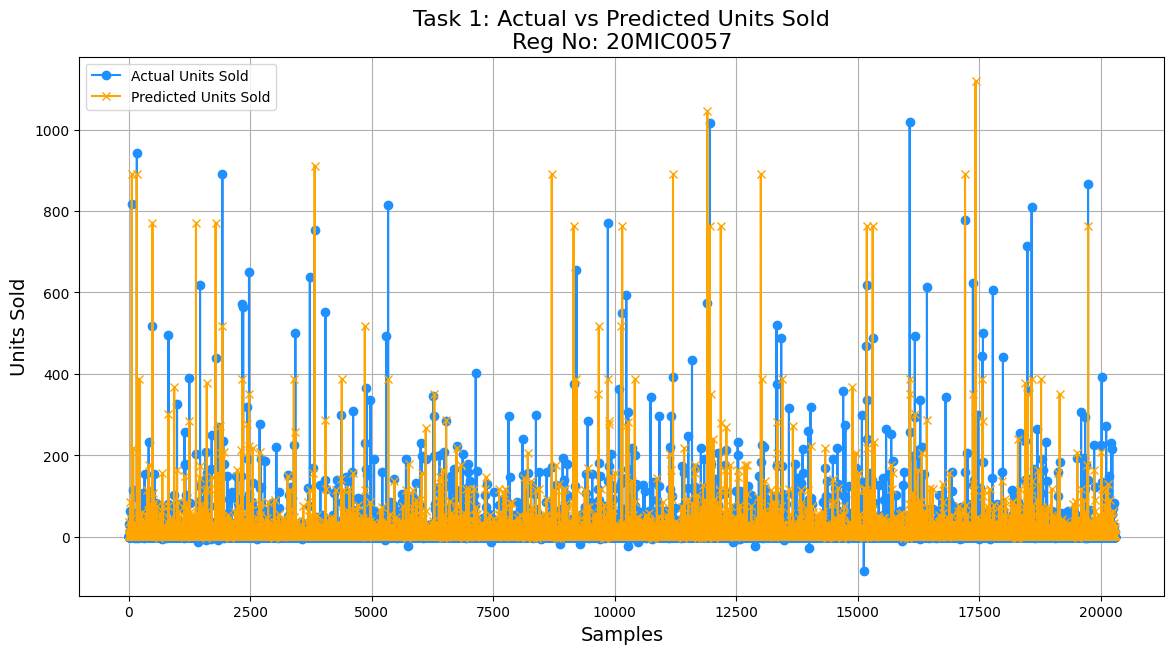

In [36]:
plt.figure(figsize=(14, 7))
plt.plot(y_val.values, label='Actual Units Sold', color='dodgerblue', marker='o')
plt.plot(y_val_pred, label='Predicted Units Sold', color='orange', marker='x')
plt.title('Task 1: Actual vs Predicted Units Sold\nReg No: 20MIC0057', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Units Sold', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


Task 2: Predict Without unit sales without using ad spend data

In [37]:
# drop ad_spend column
X_train_no_ad = X_train_scaled.drop(columns=['ad_spend'])
X_val_no_ad = X_val_scaled.drop(columns=['ad_spend'])
X_test_no_ad = X_test_scaled.drop(columns=['ad_spend'])

# model without ad spend
model_no_ad = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model_no_ad.fit(X_train_no_ad, y_train)

y_val_no_ad_pred = model_no_ad.predict(X_val_no_ad)
mse_no_ad = mean_squared_error(y_val, y_val_no_ad_pred)
print(f"Validation MSE without ad_spend: {mse_no_ad}")

# Predict and show the results
y_test_no_ad_pred = model_no_ad.predict(X_test_no_ad)
submission_no_ad = test_df[['date', 'Item Id']].copy()
submission_no_ad['TARGET'] = y_test_no_ad_pred
print(submission_no_ad.head(15))
"""submission_no_ad.to_csv('submission_no_ad.csv', index=False)"""

Validation MSE without ad_spend: 1339.9913603024409
         date     Item Id     TARGET
0  2024-07-01  B09KDR64LT  28.154516
1  2024-07-01  B09KDTS4DC  43.566036
2  2024-07-01  B09KDTHJ6V  21.892855
3  2024-07-01  B09KDQ2BWY  25.312330
4  2024-07-01  B09KDYY3SB   2.973237
5  2024-07-01  B09KDNYCYR   2.973237
6  2024-07-01  B09KDN7PYR   2.973237
7  2024-07-01  B09KDLQ2GW   2.973237
8  2024-07-01  B0BDRTZTGX   2.973237
9  2024-07-01  B09KDVXTP4   2.973237
10 2024-07-01  B09KDPXYG3   2.973237
11 2024-07-01  B09KDW1YKQ   2.973237
12 2024-07-01  B09MR36MLJ  28.154516
13 2024-07-01  B09KDZQJ6P   2.973237
14 2024-07-01  B09MR3Y296  34.047482


"submission_no_ad.to_csv('submission_no_ad.csv', index=False)"

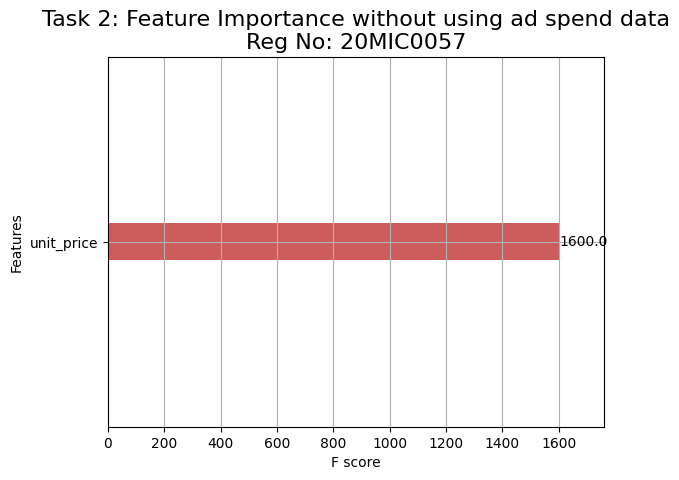

In [38]:
xgb.plot_importance(model_no_ad, max_num_features=10, importance_type='weight', color='indianred')
plt.title('Task 2: Feature Importance without using ad spend data\nReg No: 20MIC0057', fontsize=16)
plt.show()

Actual vs Predicted Units Sold without using ad spend data

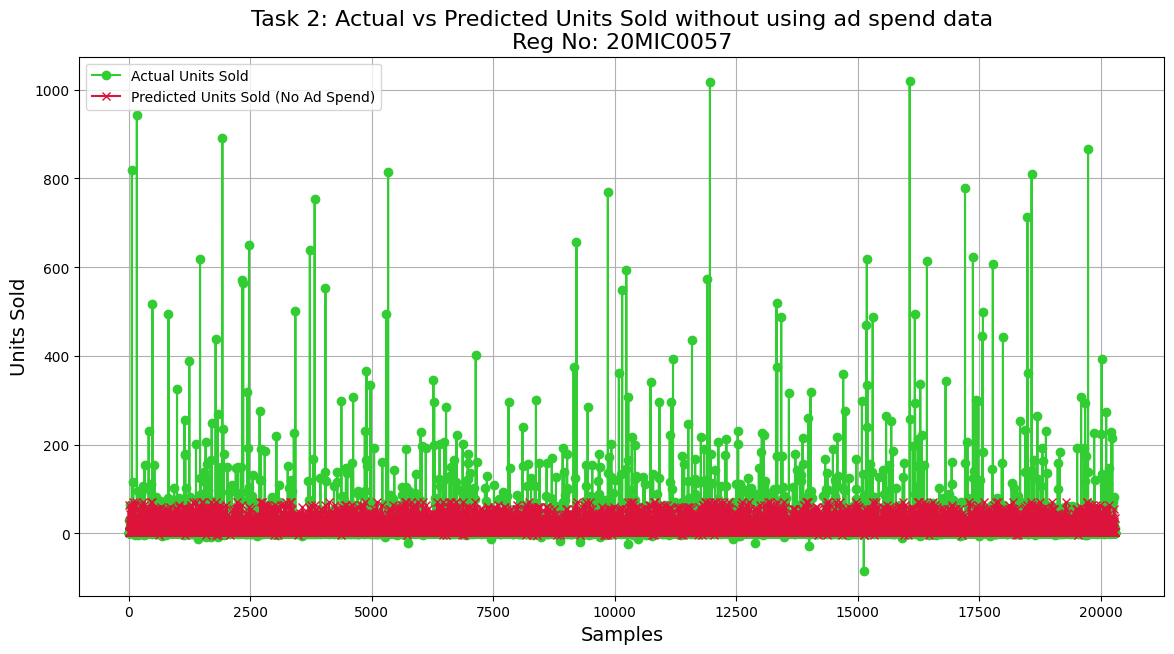

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(y_val.values, label='Actual Units Sold', color='limegreen', marker='o')
plt.plot(y_val_no_ad_pred, label='Predicted Units Sold (No Ad Spend)', color='crimson', marker='x')
plt.title('Task 2: Actual vs Predicted Units Sold without using ad spend data\nReg No: 20MIC0057', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Units Sold', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()